In [1]:
from quantum_statistics import ParticleProps, DensityCalculator, BEC
from quantum_statistics.spacial_basis import BSplineSpacialBasisFunction, BSplineSpacialBasisSet, nquad_vec
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Union
import astropy.units as u
import sparse
import cProfile
from scipy.integrate import quad_vec, quad, simps

In [2]:
def harmonic_trap(
        x: Union[float, np.ndarray],
        y: Union[float, np.ndarray],
        z: Union[float, np.ndarray],
        trap_depth: float = 200,
        waist: float = 50,
    ) -> Union[float, np.ndarray]:
    """Return a harmonic trap potential in [k_B x nK] for given position(s) in [μm].
    
        Args:
            x, y, z: position in [μm]
            trap_depth: trap depth in [k_B x nK]. Defaults to 200nK.
            waist: region in which we can model the trap as harmonic is [-waist, waist] in [μm]. Defaults to 80μm.

        Returns:
            V(x, y, z): harmonic trap potential in [k_B x nK], array of same shape as x, y, z
    """
    r_squared = x**2 + y**2 + z**2
    gaussian_profile = np.exp(-2 * r_squared / waist**2)
    return -trap_depth * gaussian_profile

## Plot the harmonic trap potential along the x-axis, i.e. V(x,0,0)
#x = np.linspace(-75, 75, 101) 
#y = np.linspace(-75, 75, 101) 
#z = np.linspace(-75, 75, 101) 
#
#fig, axs = plt.subplots(1, 3, figsize=(15, 5))
#fig.suptitle(r'Isotropic harmonic potential, $d=200nK$, $\omega=50 \mu m$', fontsize=24)
#
#axs[0].plot(x, harmonic_trap(x,0,0))
#axs[0].set_xlabel(r'$x[\mu m]$', fontsize=18)
#axs[0].set_ylabel(r'$V(x,0,0) \; [nK]$', fontsize=18)
#axs[0].set_title('V(x,0,0)', fontsize=18)
#axs[0].grid(True)
#
#axs[1].plot(x, harmonic_trap(0,y,0))
#axs[1].set_xlabel(r'$y[\mu m]$', fontsize=18)
#axs[1].set_ylabel(r'$V(0,y,0) \; [nK]$', fontsize=18)
#axs[1].set_title('V(0,y,0)', fontsize=18)
#axs[1].grid(True)
#
#axs[2].plot(x, harmonic_trap(0,0,z))
#axs[2].set_xlabel(r'$z[\mu m]$', fontsize=18)
#axs[2].set_ylabel(r'$V(0,0,z,) \; [nK]$', fontsize=18)
#axs[2].set_title('V(0,0,z)', fontsize=18)
#axs[2].grid(True)
#
#fig.tight_layout()

In [3]:
basis_set = BSplineSpacialBasisSet([(-100,100), (-80,80), (-60,60)], (3,4,5), (51,41,31), harmonic_trap)

x = np.linspace(-100, 100, 61)
y = np.linspace(-100, 100, 41) 
z = 0
coeffs = np.arange(basis_set.num_basis_funcs)

In [4]:
result_x, result_y, result_z = basis_set.get_kinetic_energy_matrix()

In [5]:
result_x.shape, result_y.shape, result_z.shape

((51, 51), (41, 41), (31, 31))

KeyboardInterrupt: 

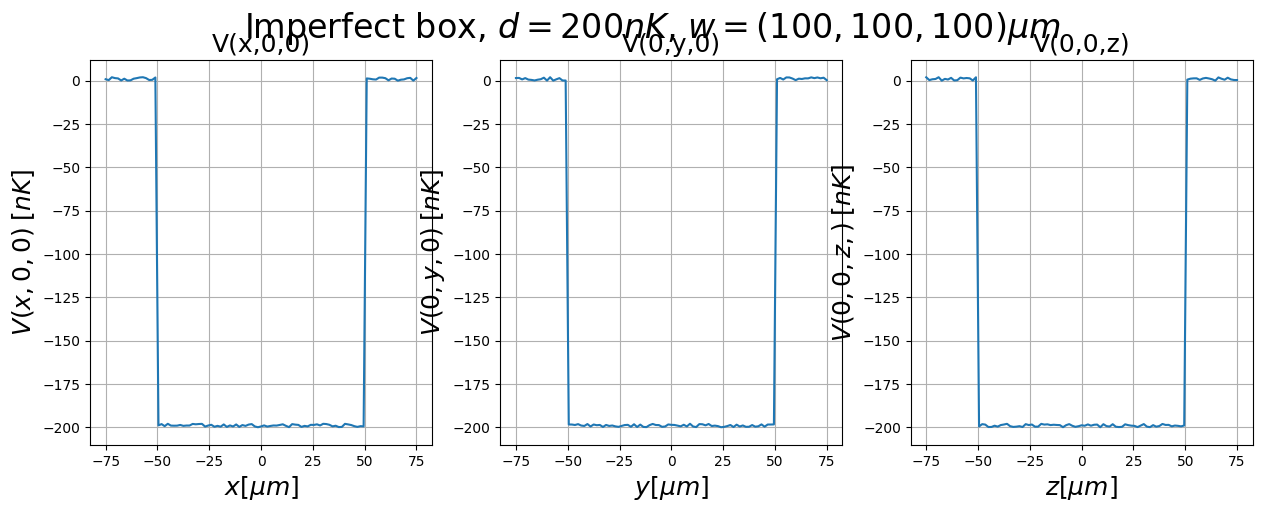

In [6]:
def imperfect_box(
        x: Union[float, np.ndarray],
        y: Union[float, np.ndarray],
        z: Union[float, np.ndarray],
        box_depth: float = 200.,
        box_width: Tuple[float] = (100., 100., 100.),
        inhomogenity: float = 0.01
) -> Union[float, np.ndarray]:
    """Return a perfect box potential of depth `box_depth` in [k_B x nK] for given position(s) in [μm].
       The size of the box in each direction around 0 is given by `box_width` in [μm].
    
        Args:
            x, y, z: position in [μm]
            box_depth: box depth in [k_B x nK]. Defaults to 2000nK.
            box_width: region [-box_width/2 μm, box_width/2 μm] is -`box_depth`nK, else potential is 0nK.
                       Defaults to (100, 100, 100)μm.
            inhomogenity: This number times `box_depth` gives the noise magnitude.

        Returns:
            V(x, y, z): box potential in [k_B x nK], array of same shape as x, y, z
    """
    # Check if the positions are within the box
    in_box = (np.abs(x) <= box_width[0] / 2) & \
             (np.abs(y) <= box_width[1] / 2) & \
             (np.abs(z) <= box_width[2] / 2)

    # Apply the potential: -box_depth inside the box, 0 outside
    perfect_box = np.where(in_box, -box_depth, 0.)
    noise = np.random.rand(*perfect_box.shape) * inhomogenity * box_depth
    return perfect_box + noise


x = np.linspace(-75, 75, 101) 
y = np.linspace(-75, 75, 101) 
z = np.linspace(-75, 75, 101) 

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(r'Imperfect box, $d=200nK$, $w=(100, 100, 100) \mu m$', fontsize=24)

axs[0].plot(x, imperfect_box(x,0,0))
axs[0].set_xlabel(r'$x[\mu m]$', fontsize=18)
axs[0].set_ylabel(r'$V(x,0,0) \; [nK]$', fontsize=18)
axs[0].set_title('V(x,0,0)', fontsize=18)
axs[0].grid(True)

axs[1].plot(x, imperfect_box(0,y,0))
axs[1].set_xlabel(r'$y[\mu m]$', fontsize=18)
axs[1].set_ylabel(r'$V(0,y,0) \; [nK]$', fontsize=18)
axs[1].set_title('V(0,y,0)', fontsize=18)
axs[1].grid(True)

axs[2].plot(x, imperfect_box(0,0,z))
axs[2].set_xlabel(r'$z[\mu m]$', fontsize=18)
axs[2].set_ylabel(r'$V(0,0,z,) \; [nK]$', fontsize=18)
axs[2].set_title('V(0,0,z)', fontsize=18)
axs[2].grid(True)

fig.tight_layout()

In [ ]:
basis_set = BSplineSpacialBasisSet((-100,100), (-100,100), (-100,100), 3, 51, harmonic_trap)
splines_x, spline_y, spline_z = basis_set.splines_x, basis_set.splines_y[23], basis_set.splines_z[23]

In [ ]:
basis_set.N_basis_functions

103823

In [ ]:
x = np.linspace(-100, 100, 101)
y = 0
z = 0

basis_set.basis_functions[0](x, y, z).shape

(101,)

In [ ]:
a = np.array([np.array([0,0,1,2,0]), np.array([3,0,4,0,0]), np.array([0,5,0,6,0])])
a

array([[0, 0, 1, 2, 0],
       [3, 0, 4, 0, 0],
       [0, 5, 0, 6, 0]])

In [ ]:
b = np.array([np.array([0,1,2,3,0]), np.array([0,0,4,0,0]), np.array([0,0,0,5,6])])
b

array([[0, 1, 2, 3, 0],
       [0, 0, 4, 0, 0],
       [0, 0, 0, 5, 6]])

In [ ]:
# Non-zero indices for 'a' and 'b'
nonzero_indices_a = np.nonzero(a)
nonzero_indices_b = np.nonzero(b)

# Fetching non-zero elements
nonzero_elements_a = a[nonzero_indices_a]
nonzero_elements_b = b[nonzero_indices_b]

In [ ]:
a.shape, nonzero_elements_a.shape

((3, 5), (6,))

In [ ]:
np.einsum('ix,jy->ijxy', nonzero_elements_a[:,np.newaxis], nonzero_elements_b[:, np.newaxis]).shape

(6, 6, 1, 1)

In [ ]:
# Preparing for optimized computation
# The result array will have shape (3, 3, 5, 5) as per 'ix, jy -> ijxy'
result = np.zeros((3, 3, 5, 5))

# Performing the operation only on non-zero elements
for i, (row_a, col_a) in enumerate(zip(*nonzero_indices_a)):
    for j, (row_b, col_b) in enumerate(zip(*nonzero_indices_b)):
        result[row_a, row_b, col_a, col_b] = nonzero_elements_a[i] * nonzero_elements_b[j]

result.shape, result.nonzero()  # Checking the shape and non-zero elements in the result

((3, 3, 5, 5),
 (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]),
  array([0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2,
         2, 2, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2]),
  array([2, 2, 2, 3, 3, 3, 2, 3, 2, 2, 3, 3, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0,
         2, 2, 1, 1, 1, 3, 3, 3, 1, 3, 1, 1, 3, 3]),
  array([1, 2, 3, 1, 2, 3, 2, 2, 3, 4, 3, 4, 1, 2, 3, 1, 2, 3, 2, 2, 3, 4,
         3, 4, 1, 2, 3, 1, 2, 3, 2, 2, 3, 4, 3, 4])))

In [ ]:
result1 = np.einsum('ix,jy->ijxy', a, b)
result1.shape, result1.nonzero()

((3, 3, 5, 5),
 (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]),
  array([0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2,
         2, 2, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2]),
  array([2, 2, 2, 3, 3, 3, 2, 3, 2, 2, 3, 3, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0,
         2, 2, 1, 1, 1, 3, 3, 3, 1, 3, 1, 1, 3, 3]),
  array([1, 2, 3, 1, 2, 3, 2, 2, 3, 4, 3, 4, 1, 2, 3, 1, 2, 3, 2, 2, 3, 4,
         3, 4, 1, 2, 3, 1, 2, 3, 2, 2, 3, 4, 3, 4])))

In [ ]:
coeffs = np.random.rand(basis_set.N_basis_functions)

x = np.linspace(-100, 100, 101)
y = 0
z = 0

n = basis_set.expand(coeffs, x, y, z)
#plt.plot(x, basis_set.expand(coeffs, x, y, z))

TypeError: BSplineSpacialBasisSet.expand() takes from 3 to 4 positional arguments but 5 were given

In [ ]:
na = ParticleProps(
    name='Na',
    species='boson',
    m=3.8175405e-26,
    N_particles=200000,
    T=0,
    V_trap=None,
    a_s=2.75e-9,
)

k = ParticleProps(
    name='K',
    species='fermion',
    m=1.642e-26,
    N_particles=200000,
    T=0,
    V_trap=None,
)

In [ ]:
calc = DensityCalculator([na, k])

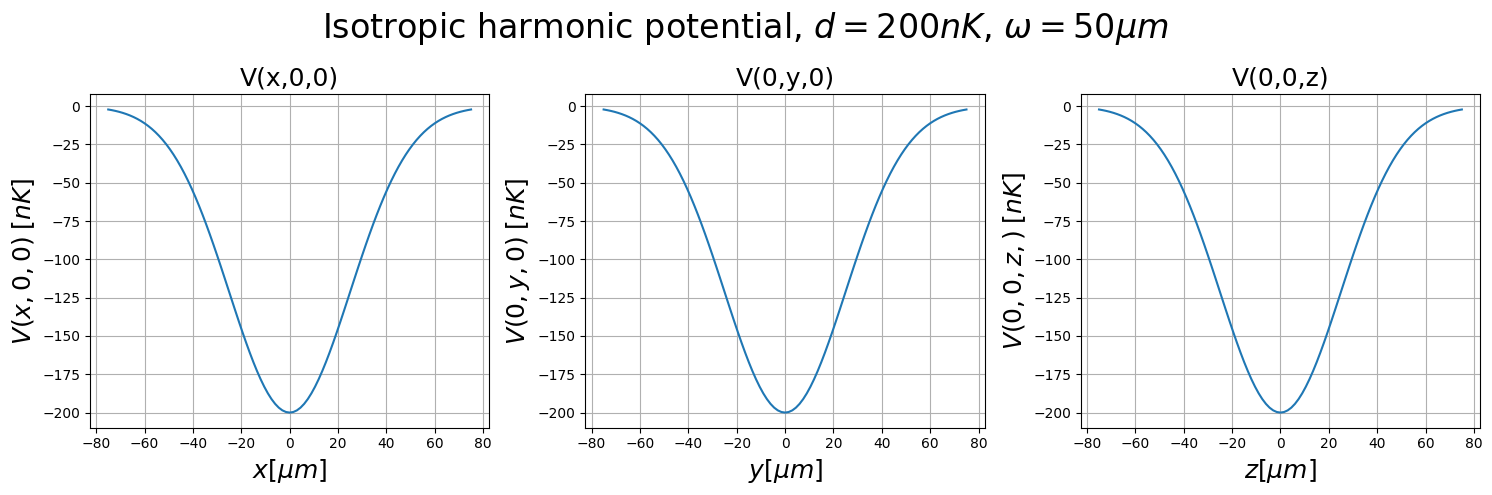

In [ ]:
def harmonic_trap(
        x: Union[float, np.ndarray],
        y: Union[float, np.ndarray],
        z: Union[float, np.ndarray],
        trap_depth: float = 200,
        waist: float = 50,
    ) -> Union[float, np.ndarray]:
    """Return a harmonic trap potential in [k_B x nK] for given position(s) in [μm].
    
        Args:
            x, y, z: position in [μm]
            trap_depth: trap depth in [k_B x nK]. Defaults to 200nK.
            waist: region in which we can model the trap as harmonic is [-waist, waist] in [μm]. Defaults to 80μm.

        Returns:
            V(x, y, z): harmonic trap potential in [k_B x nK], array of same shape as x, y, z
    """
    r_squared = x**2 + y**2 + z**2
    gaussian_profile = np.exp(-2 * r_squared / waist**2)
    return -trap_depth * gaussian_profile

# Plot the harmonic trap potential along the x-axis, i.e. V(x,0,0)
x = np.linspace(-75, 75, 101) 
y = np.linspace(-75, 75, 101) 
z = np.linspace(-75, 75, 101) 

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(r'Isotropic harmonic potential, $d=200nK$, $\omega=50 \mu m$', fontsize=24)

axs[0].plot(x, harmonic_trap(x,0,0))
axs[0].set_xlabel(r'$x[\mu m]$', fontsize=18)
axs[0].set_ylabel(r'$V(x,0,0) \; [nK]$', fontsize=18)
axs[0].set_title('V(x,0,0)', fontsize=18)
axs[0].grid(True)

axs[1].plot(x, harmonic_trap(0,y,0))
axs[1].set_xlabel(r'$y[\mu m]$', fontsize=18)
axs[1].set_ylabel(r'$V(0,y,0) \; [nK]$', fontsize=18)
axs[1].set_title('V(0,y,0)', fontsize=18)
axs[1].grid(True)

axs[2].plot(x, harmonic_trap(0,0,z))
axs[2].set_xlabel(r'$z[\mu m]$', fontsize=18)
axs[2].set_ylabel(r'$V(0,0,z,) \; [nK]$', fontsize=18)
axs[2].set_title('V(0,0,z)', fontsize=18)
axs[2].grid(True)

fig.tight_layout()

In [ ]:
plot = SpacialPlot(harmonic_trap)

NameError: name 'SpacialPlot' is not defined

In [ ]:
xpos = np.array([np.linspace(-75, 75, 101), 0, 0]) * u.um

/tmp/ipykernel_492369/4222929615.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xpos = np.array([np.linspace(-75, 75, 101), 0, 0]) * u.um


TypeError: unsupported operand type(s) for *: 'numpy.ndarray' and 'PrefixUnit'

In [ ]:
plot.plot_1d_overview(
    [np.linspace(-75, 75, 101), 0,0]*u.um, 
    [0, np.linspace(-75, 75, 101),0]*u.um, 
    [0,0, np.linspace(-75, 75, 101)]*u.um, 
    suptitle='Isotropic harmonic potential, $d=200nK$, $\omega=50 \mu m$', 
    xlabel=r'$x,y,z[\mu m]$', 
    ylabel=r'$V(x,y,z) \; [nK]$')

TypeError: can't multiply sequence by non-int of type 'PrefixUnit'

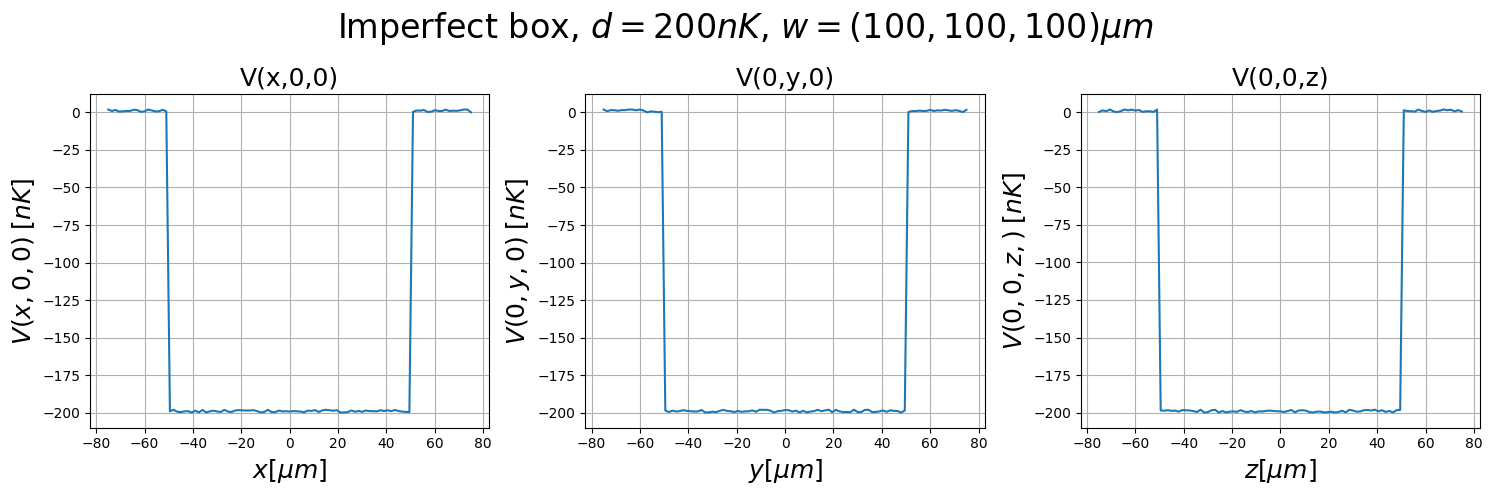

In [ ]:
def imperfect_box(
        x: Union[float, np.ndarray],
        y: Union[float, np.ndarray],
        z: Union[float, np.ndarray],
        box_depth: float = 200.,
        box_width: Tuple[float] = (100., 100., 100.),
        inhomogenity: float = 0.01
) -> Union[float, np.ndarray]:
    """Return a perfect box potential of depth `box_depth` in [k_B x nK] for given position(s) in [μm].
       The size of the box in each direction around 0 is given by `box_width` in [μm].
    
        Args:
            x, y, z: position in [μm]
            box_depth: box depth in [k_B x nK]. Defaults to 2000nK.
            box_width: region [-box_width/2 μm, box_width/2 μm] is -`box_depth`nK, else potential is 0nK.
                       Defaults to (100, 100, 100)μm.
            inhomogenity: This number times `box_depth` gives the noise magnitude.

        Returns:
            V(x, y, z): box potential in [k_B x nK], array of same shape as x, y, z
    """
    # Check if the positions are within the box
    in_box = (np.abs(x) <= box_width[0] / 2) & \
             (np.abs(y) <= box_width[1] / 2) & \
             (np.abs(z) <= box_width[2] / 2)

    # Apply the potential: -box_depth inside the box, 0 outside
    perfect_box = np.where(in_box, -box_depth, 0.)
    noise = np.random.rand(*perfect_box.shape) * inhomogenity * box_depth
    return perfect_box + noise


x = np.linspace(-75, 75, 101) 
y = np.linspace(-75, 75, 101) 
z = np.linspace(-75, 75, 101) 

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(r'Imperfect box, $d=200nK$, $w=(100, 100, 100) \mu m$', fontsize=24)

axs[0].plot(x, imperfect_box(x,0,0))
axs[0].set_xlabel(r'$x[\mu m]$', fontsize=18)
axs[0].set_ylabel(r'$V(x,0,0) \; [nK]$', fontsize=18)
axs[0].set_title('V(x,0,0)', fontsize=18)
axs[0].grid(True)

axs[1].plot(x, imperfect_box(0,y,0))
axs[1].set_xlabel(r'$y[\mu m]$', fontsize=18)
axs[1].set_ylabel(r'$V(0,y,0) \; [nK]$', fontsize=18)
axs[1].set_title('V(0,y,0)', fontsize=18)
axs[1].grid(True)

axs[2].plot(x, imperfect_box(0,0,z))
axs[2].set_xlabel(r'$z[\mu m]$', fontsize=18)
axs[2].set_ylabel(r'$V(0,0,z,) \; [nK]$', fontsize=18)
axs[2].set_title('V(0,0,z)', fontsize=18)
axs[2].grid(True)

fig.tight_layout()

In [ ]:
adaptive_basis = Adaptive3DBSplineBasis(
    domain=((-100,100), (-100,100), (-100,100)), 
    degrees=(4,4,4), 
    num_knots=(81,81,81), 
    potential_function=harmonic_trap, 
    use_potential=True,
)

In [ ]:
basis = BSplineBasis1D((-100,100), 4, 81)

In [ ]:
basis.basis_functions[:]

AttributeError: 'BSpline' object has no attribute 'plot'

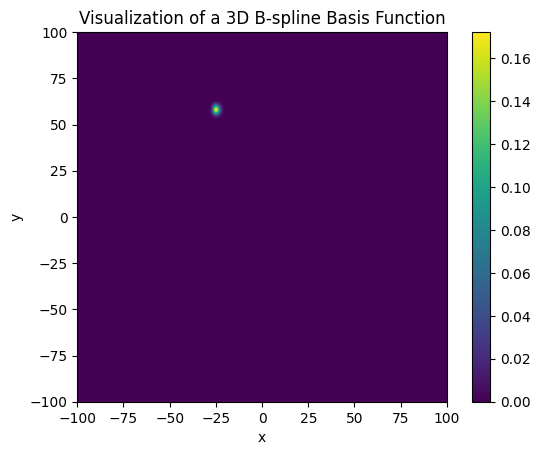

In [ ]:
# Evaluate a specific 3D B-spline at a point (x, y, z) in sparse format
x = np.linspace(-100, 100, 1000)
y = np.linspace(-100, 100, 1000)
z = np.array([0])  # Single z value for a 2D slice
i, j, k = 65,32,41  # Indices of the B-spline basis function in each dimension
value_sparse = adaptive_basis.evaluate_sparse(x, y, z, i, j, k)

# Convert to dense format for visualization
value_dense = value_sparse.toarray().reshape(len(x), len(y))

plt.imshow(value_dense, origin='lower', extent=(-100, 100, -100, 100))
plt.colorbar()
plt.title("Visualization of a 3D B-spline Basis Function")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

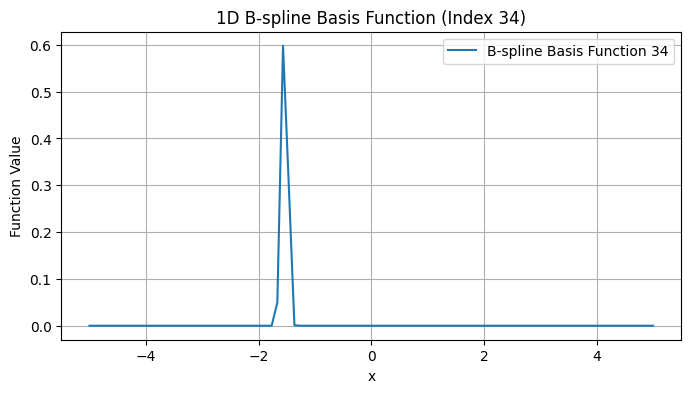

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_1d_bspline(bspline_basis, index, num_points=100):
    """
    Plots a 1D B-spline basis function.

    :param bspline_basis: An instance of the BSplineBasis1D class.
    :param index: The index of the B-spline basis function to plot.
    :param num_points: Number of points to use for plotting.
    """
    # Define the range for plotting based on the domain of the B-spline
    x_min, x_max = bspline_basis.knots[0], bspline_basis.knots[-1]
    x_values = np.linspace(x_min, x_max, num_points)

    # Evaluate the B-spline basis function at each point
    y_values = [bspline_basis.evaluate(x, index) for x in x_values]

    # Plotting
    plt.figure(figsize=(8, 4))
    plt.plot(x_values, y_values, label=f'B-spline Basis Function {index}')
    plt.title(f'1D B-spline Basis Function (Index {index})')
    plt.xlabel('x')
    plt.ylabel('Function Value')
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage
domain = (-5, 5)  # domain for the B-spline
degree = 3  # degree of the B-spline
num_knots = 101  # number of knots

# Create an instance of the BSplineBasis1D class
bspline_basis = BSplineBasis1D(domain, degree, num_knots)

# Plot a specific B-spline basis function
plot_1d_bspline(bspline_basis, index=34)  # Adjust the index as needed


In [ ]:
import numpy as np
from abc import ABC, abstractmethod
from scipy.interpolate import BSpline
from scipy.sparse import csr_matrix, kron
from scipy.spatial import ConvexHull


class BSplineBasis1D:
    """
    Represents a 1D B-spline basis.

    Attributes:
        knots (np.ndarray): Knot positions for the B-spline.
        degree (int): Degree of the B-spline.
        basis_functions (list of BSpline): List of B-spline basis functions.

    Methods:
        evaluate(x, i): Evaluates the i-th B-spline basis function at x.
        evaluate_sparse(x, i): Evaluates the i-th B-spline basis function at x in a sparse format.
    """
    def __init__(
            self, 
            domain: tuple, 
            degree: int, 
            num_knots: int, 
            knots: np.ndarray = None
        ):
        """
        Initializes a 1D B-spline basis.

        Args:
            domain (tuple): The domain range (start, end) for the B-spline.
            degree (int): Degree of the B-spline.
            num_knots (int): Number of knots.
            knots (np.ndarray, optional): Custom array of knots. If None, a uniform knot vector is used.
        """
        self.knots = knots if knots is not None else np.linspace(domain[0], domain[1], num_knots+degree+1)
        self.degree = degree
        self.basis_functions = self._generate_basis()

    def _generate_basis(
            self,
        ) -> list:
        """
        Generates the list of B-spline basis functions.

        This internal method computes the B-spline basis functions based on the provided knot vector 
        and degree. Each basis function is a BSpline object.

        Returns:
            list: List of BSpline objects representing the basis functions.
        """
        basis_functions = []
        n = len(self.knots) - self.degree - 1
        for i in range(n):
            coef = np.zeros(n)
            coef[i] = 1
            spline = BSpline(self.knots, coef, self.degree)
            basis_functions.append(spline)
        return basis_functions

    def evaluate(
            self, 
            x, 
            i: int,
        ):
        """
        Evaluates the i-th B-spline basis function at a given point or points.

        Args:
            x (float or np.ndarray): Point(s) at which to evaluate the basis function.
            i (int): Index of the basis function to evaluate.

        Returns:
            The value(s) of the i-th basis function at x. Returns a scalar if x is a float,
            and a NumPy array if x is a NumPy array.
        """
        if isinstance(x, np.ndarray):
            return np.array([self.basis_functions[i](xi) for xi in x])
        else:
            return self.basis_functions[i](x)

    def evaluate_sparse(
            self, 
            x, 
            i: int,
        ) -> csr_matrix:
        """
        Evaluates the i-th B-spline basis function at a given point or points in a sparse format.

        Args:
            x (float or np.ndarray): Point(s) at which to evaluate the basis function.
            i (int): Index of the basis function to evaluate.

        Returns:
            csr_matrix: Sparse matrix representation of the basis function evaluation.
        """
        if isinstance(x, np.ndarray):
            return csr_matrix([self.basis_functions[i](xi) for xi in x])
        else:
            return csr_matrix([[self.basis_functions[i](x)]])


class Adaptive3DBSplineBasis:
    """
    Represents a 3D B-spline basis adapted to a potential function.

    Attributes:
        x_basis (BSplineBasis1D): B-spline basis for the x dimension.
        y_basis (BSplineBasis1D): B-spline basis for the y dimension.
        z_basis (BSplineBasis1D): B-spline basis for the z dimension.

    Methods:
        evaluate(x, y, z, i, j, k): Evaluates the tensor product of 3D B-spline basis functions at a given point (x, y, z).
        evaluate_sparse(x, y, z, i, j, k): Evaluates the tensor product of 3D B-spline basis functions at a given point (x, y, z) in a sparse format.
        _create_adaptive_knots_3d: Creates adaptive knot vectors for each dimension based on a 3D potential function.
    """
    def __init__(
            self, 
            domain: tuple, 
            degrees: tuple, 
            num_knots: tuple, 
            potential_function=None, 
            use_potential: bool = False
        ):
        """
        Initializes a 3D B-spline basis adapted to a potential function.

        Args:
            domain (tuple): Domain ranges for each dimension.
            degrees (tuple): Degrees of the B-splines for each dimension.
            num_knots (tuple): Number of knots for each dimension.
            potential_function (callable, optional): The trap potential function V(x, y, z).
            use_potential (bool, optional): If True, use the potential function to adaptively place knots.
        """
        if use_potential and potential_function:
            knots_x, knots_y, knots_z = self._create_adaptive_knots_3d(potential_function, domain, num_knots, degrees)
        else:
            knots_x = np.linspace(domain[0][0], domain[0][1], num_knots[0] + degrees[0] + 1)
            knots_y = np.linspace(domain[1][0], domain[1][1], num_knots[1] + degrees[1] + 1)
            knots_z = np.linspace(domain[2][0], domain[2][1], num_knots[2] + degrees[2] + 1)
        
        self.x_basis = BSplineBasis1D(domain[0], degrees[0], num_knots[0], knots_x)
        self.y_basis = BSplineBasis1D(domain[1], degrees[1], num_knots[1], knots_y)
        self.z_basis = BSplineBasis1D(domain[2], degrees[2], num_knots[2], knots_z)

    def evaluate(self, x, y, z, i, j, k):
        """
        Evaluates the tensor product of 3D B-spline basis functions at a given point (x, y, z).
        x, y, z can be either floats or arrays.

        Args:
            x, y, z: Coordinates, can be floats or NumPy arrays.
            i, j, k: Indices of the basis function in the x, y, z dimensions.

        Returns:
            The value(s) of the 3D B-spline basis function at (x, y, z).
        """
        x_val = np.array(self.x_basis.evaluate(x, i)).reshape(-1, 1, 1)
        y_val = np.array(self.y_basis.evaluate(y, j)).reshape(1, -1, 1)
        z_val = np.array(self.z_basis.evaluate(z, k)).reshape(1, 1, -1)

        return x_val * y_val * z_val

    def evaluate_sparse(self, x, y, z, i, j, k):
        """
        Evaluates the tensor product of 3D B-spline basis functions at a given point (x, y, z) in a sparse format.
        x, y, z can be either floats or arrays.

        Args:
            x, y, z: Coordinates, can be floats or NumPy arrays.
            i, j, k: Indices of the basis function in the x, y, z dimensions.

        Returns:
            csr_matrix: Sparse matrix representation of the 3D B-spline basis function evaluation.
        """
        x_eval = self.x_basis.evaluate_sparse(x, i)
        y_eval = self.y_basis.evaluate_sparse(y, j)
        z_eval = self.z_basis.evaluate_sparse(z, k)

        # Handling the tensor product in sparse format
        if isinstance(x, np.ndarray):
            x_eval = csr_matrix(x_eval)
        else:
            x_eval = csr_matrix(x_eval).transpose()

        if isinstance(y, np.ndarray):
            y_eval = csr_matrix(y_eval)
        else:
            y_eval = csr_matrix(y_eval).transpose()

        if isinstance(z, np.ndarray):
            z_eval = csr_matrix(z_eval)
        else:
            z_eval = csr_matrix(z_eval).transpose()

        # Compute tensor product using Kronecker product
        xy_eval = kron(x_eval, y_eval)
        xyz_eval = kron(xy_eval, z_eval)

        return xyz_eval

    def _create_adaptive_knots_3d(
            self, 
            potential_function, 
            domain: tuple, 
            num_knots: tuple, 
            degrees: tuple, 
            num_samples: int = 50,
        ) -> tuple:
        """
        Creates adaptive knot vectors for each dimension based on a 3D potential function.

        Args:
            potential_function (callable): The trap potential function V(x, y, z).
            domain (tuple): Domain ranges for each dimension.
            num_knots (tuple): Number of knots for each dimension.
            degrees (tuple): Degrees of the B-splines for each dimension.
            num_samples (int, optional): Number of samples for analyzing the potential.

        Returns:
            tuple: A tuple containing three arrays of knots for the x, y, and z dimensions.
        """
        x_samples = np.linspace(domain[0][0], domain[0][1], num_samples)
        y_samples = np.linspace(domain[1][0], domain[1][1], num_samples)
        z_samples = np.linspace(domain[2][0], domain[2][1], num_samples)

        X, Y, Z = np.meshgrid(x_samples, y_samples, z_samples, indexing='ij')
        V = potential_function(X, Y, Z)

        grad_x, grad_y, grad_z = np.gradient(V, x_samples, y_samples, z_samples)

        grad_x_agg = np.max(np.abs(grad_x), axis=(1, 2))
        grad_y_agg = np.max(np.abs(grad_y), axis=(0, 2))
        grad_z_agg = np.max(np.abs(grad_z), axis=(0, 1))

        def _create_knots_from_gradient(
                gradient: np.ndarray, 
                axis_samples: np.ndarray, 
                num_knots_dim: int, 
                degree: int,
            ) -> np.ndarray:
            """
            Creates a knot vector from a gradient profile of the potential function.

            This function analyzes the gradient along one dimension and determines the placement of knots
            such that more knots are placed in regions with higher gradient magnitude.

            Args:
                gradient (np.ndarray): Gradient of the potential function along one dimension.
                axis_samples (np.ndarray): Sample points along the axis.
                num_knots_dim (int): Number of knots for this dimension.
                degree (int): Degree of the B-spline.

            Returns:
                np.ndarray: Array of knot positions for this dimension.
            """
            points = np.column_stack((axis_samples, gradient))
            hull = ConvexHull(points)
            hull_points = np.unique(points[hull.vertices, 0])
            knots = np.linspace(axis_samples[0], axis_samples[-1], num_knots_dim - len(hull_points))
            knots = np.sort(np.concatenate((knots, hull_points)))
            return np.concatenate(([axis_samples[0]] * degree, knots, [axis_samples[-1]] * degree))

        knots_x = _create_knots_from_gradient(grad_x_agg, x_samples, num_knots[0], degrees[0])
        knots_y = _create_knots_from_gradient(grad_y_agg, y_samples, num_knots[1], degrees[1])
        knots_z = _create_knots_from_gradient(grad_z_agg, z_samples, num_knots[2], degrees[2])

        return knots_x, knots_y, knots_z


In [ ]:
k = (0,1, 3, 4) * u.um

In [ ]:
type(k)

astropy.units.quantity.Quantity

In [ ]:
class BSplines1d():
    def __init__(
            self, 
            domain: tuple, 
            degree: int, 
            knots: np.ndarray,
        ):
        # Check that the domain is a tuple of length 2
        if isinstance(domain, Tuple, np.ndarray) and len(domain) == 2:
            if isinstance(domain[0], (int, float)) and isinstance(domain[1], (int, float)):
                if domain[0] < domain[1]:
                    self.domain = np.array(domain)
                else:
                    raise ValueError("domain[0] must be less than domain[1].")
            else:
                raise TypeError("domain must be a Tuple or np.ndarray of floats.")
        else:
            raise TypeError("domain must be a Tuple or np.ndarray of length 2.")

        # Check that the degree is an integer
        if isinstance(degree, int):
            self.degree = degree
        else:
            raise TypeError("degree must be an int.")

        # Check that the knots are a Sequence or np.ndarray of floats and are in the domain
        if isinstance(knots, (Sequence, np.ndarray)):
            if all(isinstance(k, (int, float)) for k in knots):
                if all(domain[0] <= k <= domain[1] for k in knots):
                    self.knots = np.array(knots)
                else:
                    raise ValueError("knots must be in the domain.")
            else:
                raise TypeError("knots must be a Sequence or np.ndarray of floats.")
        else:
            raise TypeError("knots must be a Sequence or np.ndarray.")

        self.splines_1d = self._generate_splines_1d()

        def _generate_splines_1d(
            self,
        ) -> list:
        splines_1d = []
        n = len(self.knots) - self.degree - 1
        for i in range(n):
            coef = np.zeros(n)
            coef[i] = 1
            spline = BSpline(self.knots, coef, self.degree)
            splines_1d.append(spline)
        return splines_1d